In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from scipy.stats import t
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt

In [2]:
os.chdir(r'C:\Users\WANGLIN CAI\fintech545\Week04')

In [73]:
os.getcwd()

'c:\\Users\\WANGLIN CAI\\fintech545\\Week04'

In [3]:
portfolio = pd.read_csv('Portfolio.csv')
DP = pd.read_csv('DailyPrices.csv')
DP.head(5)

,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
0,2/14/2022 0:00,432.011322,167.863144,292.261475,155.167007,291.920013,135.526001,135.300003,217.699997,242.443298,...,197.263107,64.592575,46.290192,151.118790,58.443172,377.068665,247.324020,48.182598,60.352272,66.789505
1,2/15/2022 0:00,438.978333,171.749573,297.680664,156.510498,307.476654,136.608505,136.425507,221.000000,264.702484,...,199.789520,64.328896,46.502743,159.029022,58.653572,372.440185,255.490829,49.446892,62.076630,67.673614
2,2/16/2022 0:00,439.470337,171.511032,297.333191,158.100494,307.796661,137.738007,137.487503,216.539993,264.862305,...,201.139511,64.172638,46.770744,165.211960,59.198696,377.000458,256.349976,50.203476,61.990410,65.915215
3,2/17/2022 0:00,430.082642,167.863144,288.626679,154.652496,292.116669,132.539002,132.308502,207.710007,244.841064,...,194.109894,64.514450,47.473091,157.448944,58.615318,378.822571,248.439911,48.600708,59.921181,64.019295
4,2/18/2022 0:00,427.297852,166.292648,285.846893,152.601502,285.660004,130.403000,130.467499,206.160004,236.199127,...,193.984528,64.455841,47.815025,157.380234,58.385788,376.571686,245.042847,48.381695,59.700851,64.981995


In [ ]:
# Q1

In [208]:
sigma = 1
price_prev = 100

# return
rt = np.random.normal(0, sigma, 100000)

price_brownian = price_prev + rt
price_arithmetic = price_prev * (1 + rt)
price_log = price_prev * np.exp(rt)

theory_mean_cla = price_prev
theory_std_cla = sigma
print(np.mean(price_brownian), np.std(price_brownian))
print(theory_mean_cla, theory_std_cla)

theory_mean_ari = price_prev
theory_std_ari = price_prev * sigma
print(np.mean(price_arithmetic), np.std(price_arithmetic))
print(theory_mean_ari, theory_std_ari)

# log price
theory_mean_geo = np.log(price_prev)
theory_std_geo = 1

print(np.mean(np.log(price_log)), np.std(np.log(price_log)))
print(theory_mean_geo, theory_std_geo)


100.00158777650971 0.9982961730041116
100 1
100.15877765097063 99.82961730041116
100 100
4.606757962497798 0.9982961730041117
4.605170185988092 1


C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_11660\2352258697.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(price_brownian, ax=axes[0])
C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_11660\2352258697.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(price_arithmetic, ax=axes[1])


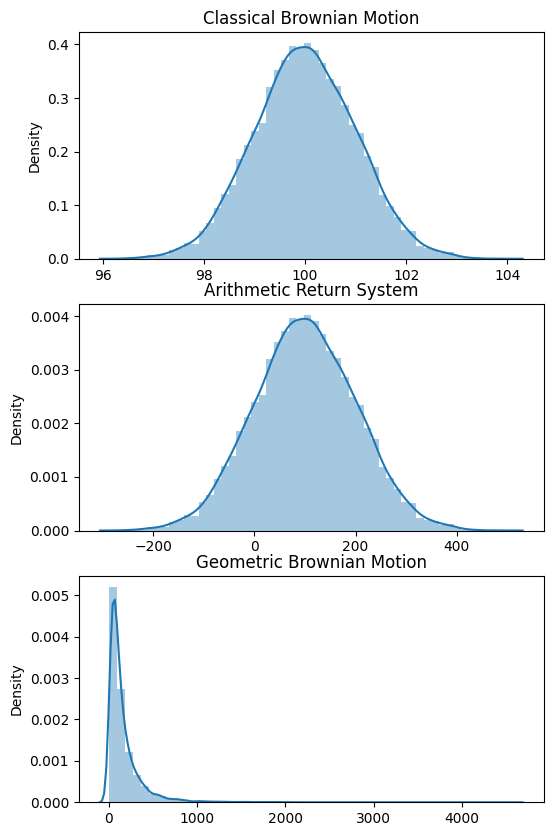

In [207]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
sns.distplot(price_brownian, ax=axes[0])
sns.distplot(price_arithmetic, ax=axes[1])
sns.distplot(price_log, ax=axes[2])
axes[0].set_title("Classical Brownian Motion")
axes[1].set_title("Arithmetic Return System")
axes[2].set_title("Geometric Brownian Motion")
plt.show()

In [ ]:
# Q2 code

In [4]:
vars = list(DP.columns)
vars.remove('Date')
p = np.array(DP[vars])
p.shape

(249, 100)

In [5]:
def return_calculate(prices: pd.DataFrame, method: str = "DISCRETE", dateColumn: str = "Date"):

    vars = list(prices.columns)
    nVars = len(vars)
    vars.remove(dateColumn)
    if nVars == len(vars):
        raise ValueError("dateColumn: " + dateColumn + " not in DataFrame: " + str(vars))
    nVars = nVars-1

    p = np.array(prices[vars])
    n = p.shape[0]
    m = p.shape[1]
    p2 = np.empty((n-1,m))
    
    for i in range(n-1):
        for j in range(m):
            p2[i,j] = p[i+1,j] / p[i,j]

    if method.upper() == "DISCRETE":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError("method: " + method + " must be in (\"LOG\",\"DISCRETE\")")

    dates = prices[dateColumn][1:n]
    out = pd.DataFrame({dateColumn: dates})
    for i in range(nVars):
        out[vars[i]] = p2[:,i]
    return out

In [6]:
# arithmetic return for all prices
all_return = return_calculate(DP, "DISCRETE", "Date")
all_return.head(5)

C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_76728\1745945367.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,2/15/2022 0:00,0.016127,0.023152,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028572,0.013237
2,2/16/2022 0:00,0.001121,-0.001389,-0.001167,0.010159,0.001041,0.008268,0.007784,-0.020181,0.000604,...,0.006757,-0.002429,0.005763,0.038879,0.009294,0.012244,0.003363,0.015301,-0.001389,-0.025984
3,2/17/2022 0:00,-0.021361,-0.021269,-0.029282,-0.021809,-0.050943,-0.037746,-0.037669,-0.040778,-0.075591,...,-0.034949,0.005326,0.015017,-0.046988,-0.009855,0.004833,-0.030857,-0.031925,-0.033380,-0.028763
4,2/18/2022 0:00,-0.006475,-0.009356,-0.009631,-0.013262,-0.022103,-0.016116,-0.013914,-0.007462,-0.035296,...,-0.000646,-0.000908,0.007203,-0.000436,-0.003916,-0.005942,-0.013674,-0.004506,-0.003677,0.015038
5,2/22/2022 0:00,-0.010732,-0.017812,-0.000729,-0.015753,-0.041366,-0.004521,-0.008163,-0.019790,-0.010659,...,0.009494,0.007121,-0.008891,0.003243,-0.001147,-0.000673,0.008342,-0.037654,-0.002246,-0.013605


In [7]:
# demean the return for META
Meta = all_return["META"] - all_return["META"].mean()

# check if the mean is zero
print(Meta.mean())

# set alpha
alpha = 0.05

sd = Meta.std()
sd

1.6787646541711037e-18


0.039882922468254534

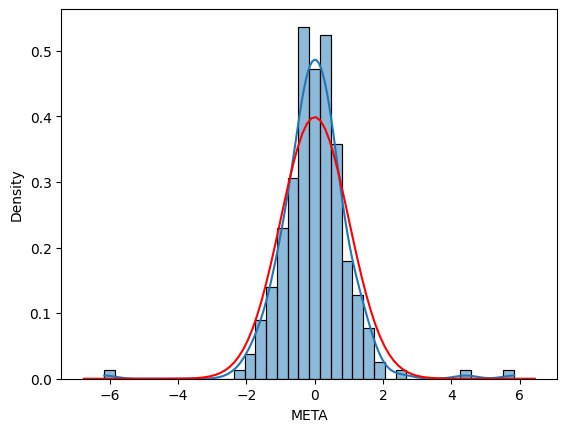

In [9]:
q = Meta/sd

hist_plot = sns.histplot(q, kde = True, stat="density")
xmin, xmax = hist_plot.get_xlim()
normal_x = np.linspace(xmin, xmax, 100)
hist_plot.plot(normal_x, norm.pdf(normal_x), color = 'red')

0.06560156967533286
0.09278155189455961


<BarContainer object of 2 artists>

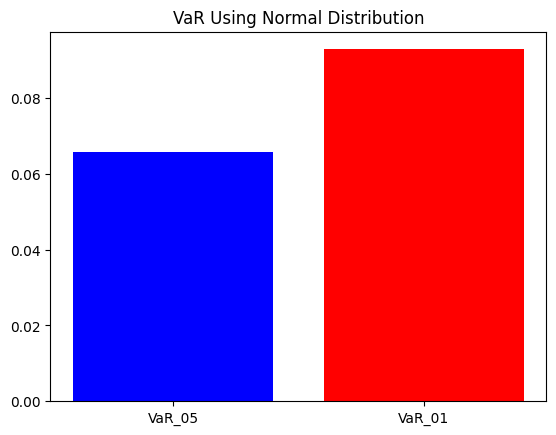

In [22]:
# 1. normal distribution

#VaR_05 = -quantile(Normal(0,sd),.05)
#VaR_01 = -quantile(Normal(0,sd),.01)

VaR_05_q1 = -norm.ppf(0.05, loc = 0, scale = sd)
VaR_01_q1 = -norm.ppf(0.01, loc = 0, scale = sd)
print(VaR_05_q1)
print(VaR_01_q1)
plt.title('VaR Using Normal Distribution')
plt.bar(['VaR_05','VaR_01'],[VaR_05_q1, VaR_01_q1], color = ['blue','red'])

In [64]:
np.asmatrix(Meta).shape

(1, 248)

In [18]:
# 2. normal distribution with Exponentially Weighted Variance (lambda = 0.94)
def get_weight(array, L):
    
    nrows = len(array)
    weights = np.zeros(nrows)
    
    for i in range(1,nrows+1):
        weights[i-1] = (1 - L) * (L**(i-1))
        
    return weights/weights.sum()

#weights = getweight(0.97,DR.shape[0])

def weighted_variance(array, L):
    
    weights = get_weight(array, L)
    w_v = 0
    
    index = 0
    for i in array.index:
        w = weights[index]
        index += 1
        
        x = array[i]-array.mean()
        w_v += w*x**2
        
    return w_v

In [19]:
ewv = weighted_variance(Meta[::-1], 0.94)
sd2 = np.sqrt(ewv)
sd2

0.05555829372358195

0.09138526093846902
0.12924791848919145


<BarContainer object of 2 artists>

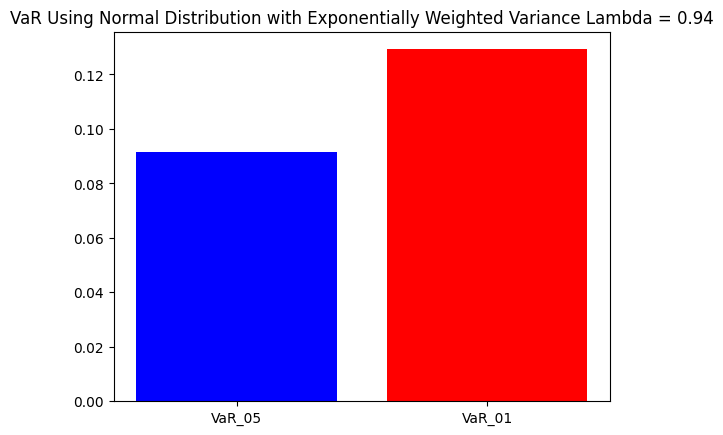

In [21]:
VaR_05_q2 = -norm.ppf(0.05, loc = 0, scale = sd2)
VaR_01_q2 = -norm.ppf(0.01, loc = 0, scale = sd2)
print(VaR_05_q2)
print(VaR_01_q2)
plt.title('VaR Using Normal Distribution with Exponentially Weighted Variance Lambda = 0.94')
plt.bar(['VaR_05','VaR_01'],[VaR_05_q2, VaR_01_q2],color = ['blue','red'])

In [23]:
# 3. MLE fitted T distribution 

def calcLogLikelihood_t(n):
    f = 1
    for i in Meta:
        f = f * t.pdf(i,n,scale=sd)
    return -np.log(f)

res_t = minimize(calcLogLikelihood_t, 10, method = 'BFGS', options={'disp': True})

res_t.x


Optimization terminated successfully.
         Current function value: -463.957934
         Iterations: 6
         Function evaluations: 18
         Gradient evaluations: 9


array([8.84777824])

0.0732531532504567
0.1129305704912018


<BarContainer object of 2 artists>

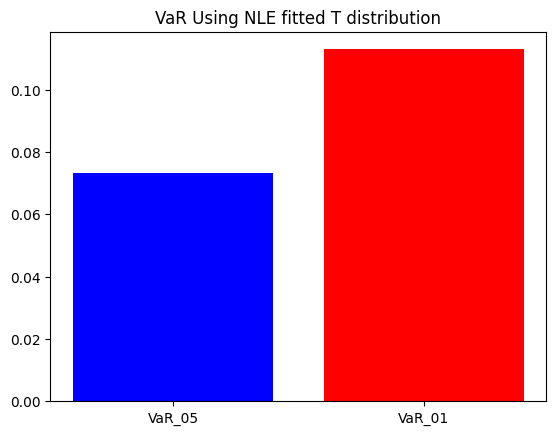

In [24]:
VaR_05_q3 = -t.ppf(0.05, df = 8.848, scale = sd)
VaR_01_q3 = -t.ppf(0.01, df = 8.848, scale = sd)
print(VaR_05_q3)
print(VaR_01_q3)
plt.title('VaR Using NLE fitted T distribution')
plt.bar(['VaR_05','VaR_01'],[VaR_05_q3, VaR_01_q3],color = ['blue','red'])

0.06588072152825065
0.09306070374747741


<BarContainer object of 2 artists>

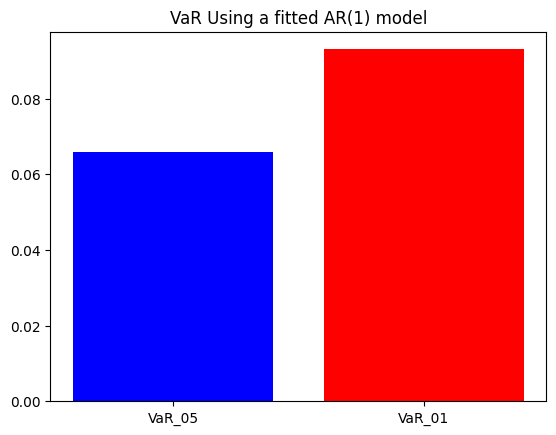

In [25]:
# 4. fitted AR(1) Model
ar_model = AutoReg(Meta, lags = 1).fit()

ar_model.params
# so the model is xt =  -0.000062 + 0.007233xt-1 + wt

VaR_05_q4 = - (-0.000062 + 0.007233*Meta[248] + norm.ppf(0.05, loc = 0, scale = sd))
VaR_01_q4 = - (-0.000062 + 0.007233*Meta[248] + norm.ppf(0.01, loc = 0, scale = sd))
print(VaR_05_q4)
print(VaR_01_q4)
plt.title('VaR Using a fitted AR(1) model')
plt.bar(['VaR_05','VaR_01'],[VaR_05_q4, VaR_01_q4],color = ['blue','red'])

0.05590681367337082
0.07770676546064272


<BarContainer object of 2 artists>

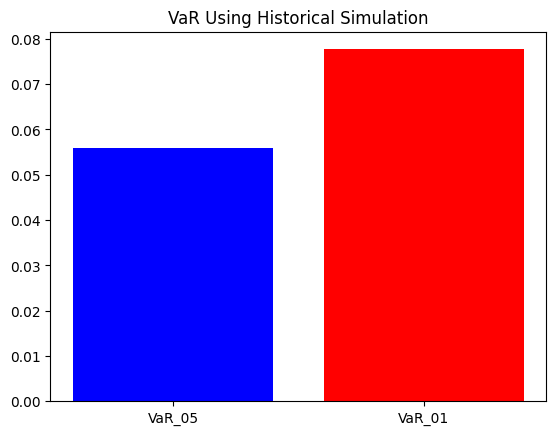

In [28]:
# 5. Historic Simulation
N = 10000

# here we use the same weight for the return
# therefore, the chance for each day being selected is the same
choice = np.random.randint(low = 1, high = 248, size = 10000)
simulated_return = sorted(Meta[choice])
#simulated_return[499]
H_VaR_05 = - np.quantile(simulated_return, 0.05)
H_VaR_01 = - np.quantile(simulated_return, 0.01)
print(H_VaR_05)
print(H_VaR_01)
plt.title('VaR Using Historical Simulation')
plt.bar(['VaR_05','VaR_01'],[H_VaR_05, H_VaR_01],color = ['blue','red'])

<BarContainer object of 10 artists>

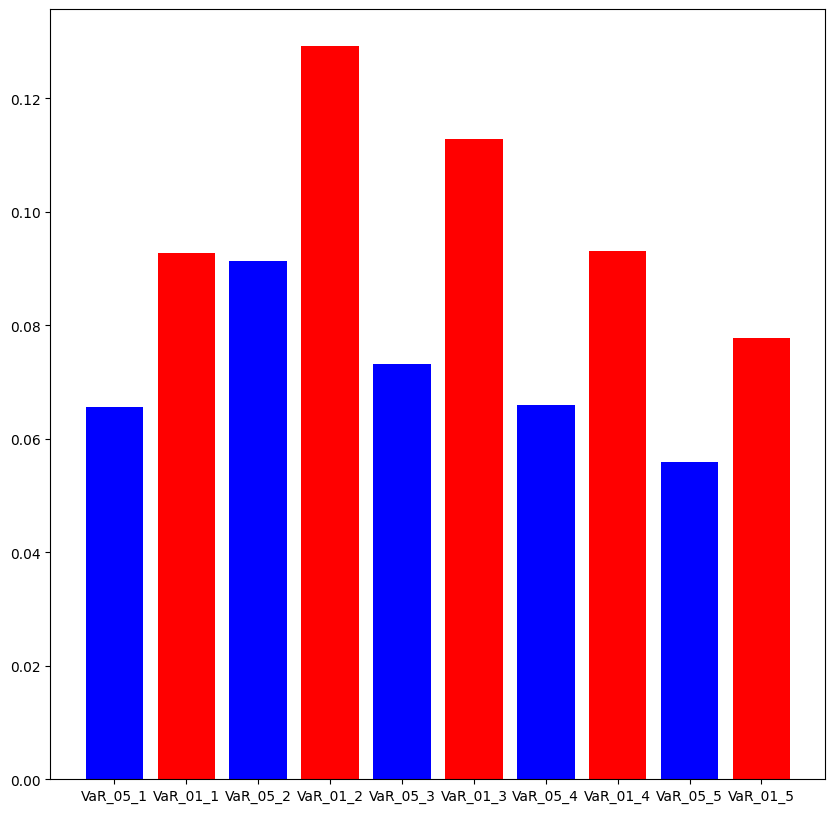

In [31]:

plt.figure(figsize=(10,10))
plt.bar(['VaR_05_1','VaR_01_1','VaR_05_2','VaR_01_2','VaR_05_3','VaR_01_3','VaR_05_4','VaR_01_4','VaR_05_5','VaR_01_5'],
        [VaR_05_q1, VaR_01_q1, VaR_05_q2, VaR_01_q2, VaR_05_q3, VaR_01_q3, VaR_05_q4, VaR_01_q4, H_VaR_05, H_VaR_01],
        color = ['blue','red','blue','red','blue','red','blue','red','blue','red'])

In [4]:
all_return = return_calculate(DP, "DISCRETE", "Date")

NameError: name 'return_calculate' is not defined

In [32]:
# q3
# demean all the return
for i in range(1,101):
    all_return.iloc[:,i] = all_return.iloc[:,i] - all_return.iloc[:,i].mean()


In [7]:
def demean(DataFrame: pd.DataFrame, DateOrNot: str = 'Y'):
    
    nrows = DataFrame.shape[0]
    ncol = DataFrame.shape[1]
    Result = pd.DataFrame(np.zeros([nrows, ncol]))
    Result.index = DataFrame.index
    
    if DateOrNot == 'Y':
        # except the first one
        for i in range(1,ncol):
            Result.iloc[:,i] = DataFrame.iloc[:,i] - DataFrame.iloc[:,i].mean()
            
        Result.drop(Result.columns[0], axis=1, inplace=True)
        Result.insert(0, 'whatever', DataFrame.iloc[:,0]) 
        Result.columns = DataFrame.columns
        
    elif DateOrNot == "N":
        # except the first one
        for i in range(0,ncol):
            Result.iloc[:,i] = DataFrame.iloc[:,i] - DataFrame.iloc[:,i].mean()
            
        Result.columns = DataFrame.columns
    else:
        raise ValueError("you can only input Y or N")
    
    return Result
    

In [8]:
all_return_demean = demean(all_return,'Y')

In [66]:
all_return_demean

,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,2/15/2022 0:00,0.016251,0.023338,0.018706,0.010018,0.053757,0.009100,0.009403,0.015175,0.091347,...,0.013489,-0.004152,0.004456,0.051421,0.001937,-0.013301,0.032537,0.026442,0.029295,0.012263
2,2/16/2022 0:00,0.001245,-0.001203,-0.001004,0.011518,0.001507,0.009381,0.008869,-0.020165,0.000139,...,0.007438,-0.002499,0.005628,0.037956,0.007630,0.011219,0.002879,0.015504,-0.000665,-0.026958
3,2/17/2022 0:00,-0.021237,-0.021083,-0.029119,-0.020450,-0.050476,-0.036633,-0.036584,-0.040761,-0.076056,...,-0.034268,0.005256,0.014881,-0.047911,-0.011518,0.003808,-0.031340,-0.031723,-0.032656,-0.029738
4,2/18/2022 0:00,-0.006350,-0.009170,-0.009468,-0.011903,-0.021637,-0.015003,-0.012830,-0.007446,-0.035761,...,0.000035,-0.000978,0.007067,-0.001360,-0.005579,-0.006967,-0.014157,-0.004304,-0.002953,0.014063
5,2/22/2022 0:00,-0.010607,-0.017626,-0.000566,-0.014394,-0.040900,-0.003408,-0.007078,-0.019774,-0.011124,...,0.010176,0.007051,-0.009026,0.002320,-0.002810,-0.001698,0.007858,-0.037452,-0.001523,-0.014580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2/3/2023 0:00,-0.010505,0.024586,-0.023457,-0.082956,0.009549,-0.026361,-0.031820,-0.011850,-0.028518,...,-0.004013,-0.011321,-0.001413,-0.003600,0.036548,0.003108,0.001853,-0.008713,-0.005230,0.000642
245,2/6/2023 0:00,-0.005987,-0.017743,-0.005952,-0.010344,0.025627,-0.016829,-0.015547,-0.002503,-0.000986,...,-0.013769,0.003875,0.000930,-0.008025,0.020348,0.020801,-0.041665,0.005308,-0.009059,-0.005570
246,2/7/2023 0:00,0.013203,0.019431,0.042186,0.000674,0.010992,0.047177,0.045252,0.029899,0.050936,...,0.000313,-0.016543,-0.008653,0.018621,-0.005253,-0.002667,0.003089,0.001654,0.009393,-0.004593
247,2/8/2023 0:00,-0.010810,-0.017467,-0.002939,-0.018815,0.023230,-0.075717,-0.073332,-0.042725,0.000978,...,-0.007788,-0.004526,-0.001424,-0.018932,-0.006080,0.001793,-0.016009,0.004309,-0.014667,0.008389


In [51]:
nrows = all_return.shape[0]
ncol = all_return.shape[1]
Result = pd.DataFrame(np.zeros([nrows, ncol]))

Result.index = all_return.index
Result

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
all_return.iloc[:,1].mean()

-0.00012451228866234673

In [79]:
np.random.randint(a = all_return.index, size = 1000, p = )

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            239, 240, 241, 242, 243, 244, 245, 246, 247, 248],
           dtype='int64', length=246)

In [12]:
all_return_demean

,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,2/15/2022 0:00,0.016251,0.023338,0.018706,0.010018,0.053757,0.009100,0.009403,0.015175,0.091347,...,0.013489,-0.004152,0.004456,0.051421,0.001937,-0.013301,0.032537,0.026442,0.029295,0.012263
2,2/16/2022 0:00,0.001245,-0.001203,-0.001004,0.011518,0.001507,0.009381,0.008869,-0.020165,0.000139,...,0.007438,-0.002499,0.005628,0.037956,0.007630,0.011219,0.002879,0.015504,-0.000665,-0.026958
3,2/17/2022 0:00,-0.021237,-0.021083,-0.029119,-0.020450,-0.050476,-0.036633,-0.036584,-0.040761,-0.076056,...,-0.034268,0.005256,0.014881,-0.047911,-0.011518,0.003808,-0.031340,-0.031723,-0.032656,-0.029738
4,2/18/2022 0:00,-0.006350,-0.009170,-0.009468,-0.011903,-0.021637,-0.015003,-0.012830,-0.007446,-0.035761,...,0.000035,-0.000978,0.007067,-0.001360,-0.005579,-0.006967,-0.014157,-0.004304,-0.002953,0.014063
5,2/22/2022 0:00,-0.010607,-0.017626,-0.000566,-0.014394,-0.040900,-0.003408,-0.007078,-0.019774,-0.011124,...,0.010176,0.007051,-0.009026,0.002320,-0.002810,-0.001698,0.007858,-0.037452,-0.001523,-0.014580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2/3/2023 0:00,-0.010505,0.024586,-0.023457,-0.082956,0.009549,-0.026361,-0.031820,-0.011850,-0.028518,...,-0.004013,-0.011321,-0.001413,-0.003600,0.036548,0.003108,0.001853,-0.008713,-0.005230,0.000642
245,2/6/2023 0:00,-0.005987,-0.017743,-0.005952,-0.010344,0.025627,-0.016829,-0.015547,-0.002503,-0.000986,...,-0.013769,0.003875,0.000930,-0.008025,0.020348,0.020801,-0.041665,0.005308,-0.009059,-0.005570
246,2/7/2023 0:00,0.013203,0.019431,0.042186,0.000674,0.010992,0.047177,0.045252,0.029899,0.050936,...,0.000313,-0.016543,-0.008653,0.018621,-0.005253,-0.002667,0.003089,0.001654,0.009393,-0.004593
247,2/8/2023 0:00,-0.010810,-0.017467,-0.002939,-0.018815,0.023230,-0.075717,-0.073332,-0.042725,0.000978,...,-0.007788,-0.004526,-0.001424,-0.018932,-0.006080,0.001793,-0.016009,0.004309,-0.014667,0.008389


In [17]:
def getweight(matrix, L):
    
    nrows = matrix.shape[0]
    weights = np.zeros(nrows)
    
    for i in range(1,nrows+1):
        weights[i-1] = (1 - L) * (L**(i-1))
        
    return weights/weights.sum()

#weights = getweight(0.97,DR.shape[0])

def weightedcov(matrix, L):
    
    weights = getweight(matrix, L)
    weightedcov = np.zeros([matrix.shape[1], matrix.shape[1]])
    
    for i in range(0,matrix.shape[1]):
        
        w = np.matrix(weights)
        x = np.asmatrix(matrix[:,i]-matrix[:,i].mean())
        w_x = np.zeros([1, x.shape[0]])
        
        for j in range(0,x.shape[0]):
            
            w_x[0,j] = w[0,j] * x[j,0]
            
        for k in range(0,matrix.shape[1]):
            
            y = np.asmatrix(matrix[:,k]-matrix[:,k].mean())
            
            weightedcov[i,k] += np.dot(w_x,y)
 
    return weightedcov


wcov = weightedcov(np.asmatrix(all_return_demean[::-1].iloc[:,1:101]), L = 0.94)
wcov

#getweight(np.asmatrix(all_return[::-1].iloc[:,1:101]), L = 0.94)



array([[ 1.26482714e-04,  1.60498225e-04,  2.11666910e-04, ...,
         1.81397640e-04,  1.20191099e-04,  1.21415100e-05],
       [ 1.60498225e-04,  3.52996482e-04,  2.69735204e-04, ...,
         2.55929668e-04,  1.51299428e-04, -6.50908573e-06],
       [ 2.11666910e-04,  2.69735204e-04,  4.97465537e-04, ...,
         3.07984284e-04,  1.52281378e-04, -3.78397686e-05],
       ...,
       [ 1.81397640e-04,  2.55929668e-04,  3.07984284e-04, ...,
         7.84934935e-04,  1.71100484e-04, -1.17601047e-05],
       [ 1.20191099e-04,  1.51299428e-04,  1.52281378e-04, ...,
         1.71100484e-04,  2.50910983e-04,  7.84124017e-06],
       [ 1.21415100e-05, -6.50908573e-06, -3.78397686e-05, ...,
        -1.17601047e-05,  7.84124017e-06,  1.26941238e-04]])

In [80]:
def weightedcov(DF, L):
    
    matrix = DF.values
    weights = getweight(DF, L)
    weightedcov = np.zeros([matrix.shape[1], matrix.shape[1]])
    
    for i in range(0,matrix.shape[1]):
        
        x = np.array(matrix[:,i]-matrix[:,i].mean())
        w_x = [weights[j]*x[j] for j in range(len(weights))]
        w_x = np.asmatrix(w_x)

        for k in range(0,matrix.shape[1]):
            
            y = np.asmatrix(matrix[:,k]-matrix[:,k].mean())
            weightedcov[i,k] += np.dot(w_x,y.T)
 
    return weightedcov

def calculate_var(data, mean=0, alpha=0.05):
    return mean - np.quantile(data, alpha)

def ewcov_normal_var(data, mean=0, alpha=0.05, nsamples=10000, L=0.94):
    ew_cov = weightedcov(data, L)
    ew_variance = ew_cov[0, 0]
    sigma = np.sqrt(ew_variance)
    simulation_ew = np.random.normal(mean, sigma, nsamples)
    var_ew = calculate_var(simulation_ew, mean, alpha)
    return var_ew

ewcov_normal_var(all_return_demean.iloc[:,1])

IndexError: tuple index out of range

In [28]:
a = [1,2,3]
b = [4,5,6]
a_b = [a[i]*b[i] for i in range(len(a))]
a_b

[4, 10, 18]

In [43]:
def exp_weighted_cov(input, lambda_=0.97):
    ror = input.values
    ror_mean = np.mean(ror, axis=0)
    dev = ror - ror_mean
    times = dev.shape[0]
    weights = np.zeros(times)
    
    for i in range(times):
        weights[times - i - 1]  = (1 - lambda_) * lambda_**i
    
    print(weights/sum(weights))
    weights_mat = np.diag(weights/sum(weights))

    cov = np.transpose(dev) @ weights_mat @ dev
    return cov

exp_weighted_cov(all_return_demean.iloc[:,1:101], lambda_=0.94)

[1.38271025e-08 1.47096836e-08 1.56485995e-08 1.66474463e-08
 1.77100493e-08 1.88404779e-08 2.00430616e-08 2.13224060e-08
 2.26834106e-08 2.41312879e-08 2.56715829e-08 2.73101946e-08
 2.90533985e-08 3.09078707e-08 3.28807135e-08 3.49794825e-08
 3.72122154e-08 3.95874632e-08 4.21143225e-08 4.48024708e-08
 4.76622030e-08 5.07044712e-08 5.39409268e-08 5.73839647e-08
 6.10467710e-08 6.49433734e-08 6.90886951e-08 7.34986118e-08
 7.81900125e-08 8.31808644e-08 8.84902813e-08 9.41385971e-08
 1.00147444e-07 1.06539834e-07 1.13340249e-07 1.20574733e-07
 1.28270992e-07 1.36458502e-07 1.45168619e-07 1.54434702e-07
 1.64292236e-07 1.74778974e-07 1.85935079e-07 1.97803275e-07
 2.10429016e-07 2.23860656e-07 2.38149634e-07 2.53350674e-07
 2.69521994e-07 2.86725525e-07 3.05027155e-07 3.24496973e-07
 3.45209546e-07 3.67244198e-07 3.90685317e-07 4.15622677e-07
 4.42151784e-07 4.70374239e-07 5.00398126e-07 5.32338432e-07
 5.66317481e-07 6.02465405e-07 6.40920644e-07 6.81830472e-07
 7.25351566e-07 7.716506

array([[ 1.26482714e-04,  1.60498225e-04,  2.11666910e-04, ...,
         1.81397640e-04,  1.20191099e-04,  1.21415100e-05],
       [ 1.60498225e-04,  3.52996482e-04,  2.69735204e-04, ...,
         2.55929668e-04,  1.51299428e-04, -6.50908573e-06],
       [ 2.11666910e-04,  2.69735204e-04,  4.97465537e-04, ...,
         3.07984284e-04,  1.52281378e-04, -3.78397686e-05],
       ...,
       [ 1.81397640e-04,  2.55929668e-04,  3.07984284e-04, ...,
         7.84934935e-04,  1.71100484e-04, -1.17601047e-05],
       [ 1.20191099e-04,  1.51299428e-04,  1.52281378e-04, ...,
         1.71100484e-04,  2.50910983e-04,  7.84124017e-06],
       [ 1.21415100e-05, -6.50908573e-06, -3.78397686e-05, ...,
        -1.17601047e-05,  7.84124017e-06,  1.26941238e-04]])

5539.374841223762
7922.672069816093


<BarContainer object of 2 artists>

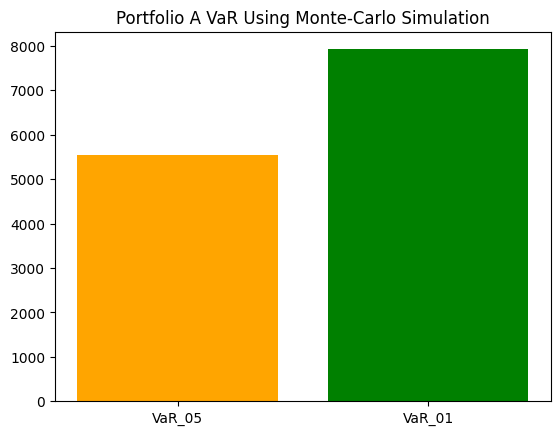

In [35]:
# use MC method to generate N possible returns for the portfolio
N = 10000

# portfolio A
portfolio_a = portfolio[portfolio['Portfolio']=='A']
stock_a = portfolio_a['Stock']
return_a = all_return[stock_a]
wcov_a = weightedcov(np.asmatrix(return_a)[::-1], L = 0.94)

DP_a = DP[stock_a]
PV_a = 0
for i in range(len(stock_a)):
    PV_a += DP_a[::-1].iloc[0,:][i] * portfolio_a['Holding'].iloc[i]
    
sim_return_a = np.random.multivariate_normal(np.zeros(len(stock_a)),wcov_a,size = N)
sim_price_a = (sim_return_a + 1) * np.array(DP_a[::-1].iloc[0,:])
sim_PV_a = np.dot(sim_price_a, np.array(portfolio_a['Holding']))
sim_PV_a = sorted(sim_PV_a)

index_05_a = int(0.05*N-1)
index_01_a = int(0.01*N-1)

VaR_05_a = PV_a - sim_PV_a[index_05_a]
VaR_01_a = PV_a - sim_PV_a[index_01_a]

print(VaR_05_a)
print(VaR_01_a)
plt.title('Portfolio A VaR Using Monte-Carlo Simulation')
plt.bar(['VaR_05','VaR_01'],[VaR_05_a, VaR_01_a],color = ['Orange','Green'])

In [85]:
sim_price_a

array([[149.79398332, 203.35854729, 140.69750554, ..., 179.26772893,
        264.73883992,  80.32602155],
       [151.52842243, 203.66146463, 144.57517136, ..., 176.50834017,
        260.55800086,  83.47951297],
       [149.09830406, 203.56068001, 141.7633855 , ..., 175.6754401 ,
        264.81958267,  82.51937759],
       ...,
       [150.08112253, 211.43406337, 138.31630996, ..., 177.95449241,
        263.38682603,  80.03595556],
       [154.13305004, 222.82180778, 138.95149017, ..., 180.55248099,
        264.86739576,  80.04806412],
       [152.30794027, 221.49292642, 138.73542547, ..., 178.56918072,
        258.9475676 ,  78.51792406]])

4486.059053554025
6535.919205486192


<BarContainer object of 2 artists>

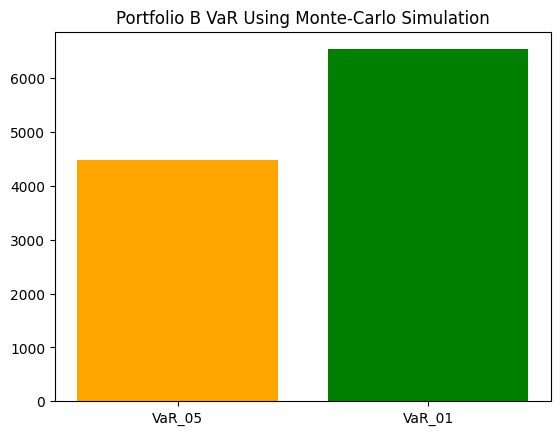

In [36]:
# portfolio B
portfolio_b = portfolio[portfolio['Portfolio']=='B']
stock_b = portfolio_b['Stock']
return_b = all_return[stock_b]
wcov_b = weightedcov(np.asmatrix(return_b)[::-1], L = 0.94)
DP_b = DP[stock_b]
PV_b = 0
for i in range(len(stock_b)):
    PV_b += DP_b[::-1].iloc[0,:][i] * portfolio_b['Holding'].iloc[i]

sim_return_b = np.random.multivariate_normal(np.zeros(len(stock_b)),wcov_b,size = N)
sim_price_b = (sim_return_b + 1) * np.array(DP_b[::-1].iloc[0,:])
sim_PV_b = np.dot(sim_price_b, np.array(portfolio_b['Holding']))
sim_PV_b = sorted(sim_PV_b)

index_05_b = int(0.05*N-1)
index_01_b = int(0.01*N-1)

VaR_05_b = PV_b - sim_PV_b[index_05_b]
VaR_01_b = PV_b - sim_PV_b[index_01_b]

print(VaR_05_b)
print(VaR_01_b)
plt.title('Portfolio B VaR Using Monte-Carlo Simulation')
plt.bar(['VaR_05','VaR_01'],[VaR_05_b, VaR_01_b],color = ['Orange','Green'])

3845.9785782470717
5318.348523460852


<BarContainer object of 2 artists>

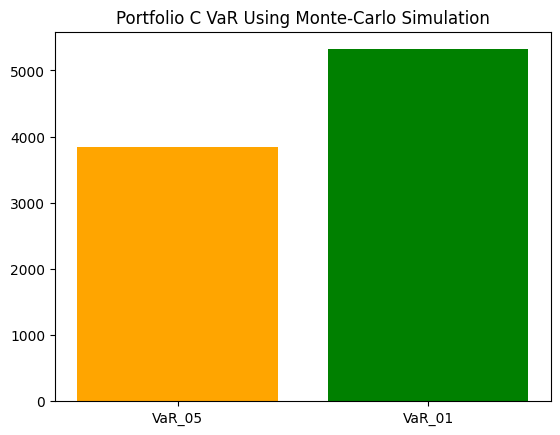

In [37]:
# portfolio C
portfolio_c = portfolio[portfolio['Portfolio']=='C']
stock_c = portfolio_c['Stock']
return_c = all_return[stock_c]
wcov_c = weightedcov(np.asmatrix(return_c)[::-1], L = 0.94)
DP_c = DP[stock_c]
PV_c = 0
for i in range(len(stock_c)):
    PV_c += DP_c[::-1].iloc[0,:][i] * portfolio_c['Holding'].iloc[i]

sim_return_c = np.random.multivariate_normal(np.zeros(len(stock_c)),wcov_c,size = N)
sim_price_c = (sim_return_c + 1) * np.array(DP_c[::-1].iloc[0,:])
sim_PV_c = np.dot(sim_price_c, np.array(portfolio_c['Holding']))
sim_PV_c = sorted(sim_PV_c)

index_05_c = int(0.05*N-1)
index_01_c = int(0.01*N-1)

VaR_05_c = PV_c - sim_PV_c[index_05_c]
VaR_01_c = PV_c - sim_PV_c[index_01_c]

print(VaR_05_c)
print(VaR_01_c)
plt.title('Portfolio C VaR Using Monte-Carlo Simulation')
plt.bar(['VaR_05','VaR_01'],[VaR_05_c, VaR_01_c],color = ['Orange','Green'])

13486.687224362046
19354.33390056691


<BarContainer object of 2 artists>

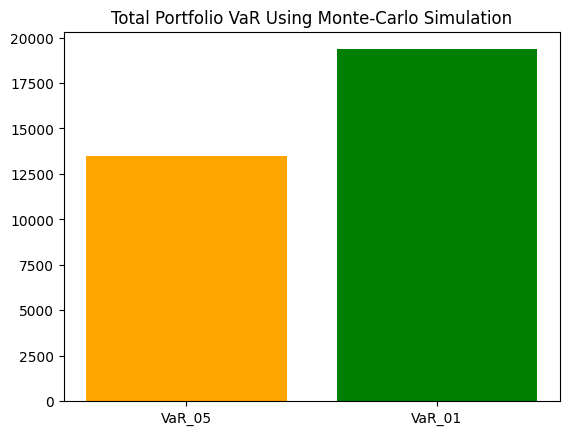

In [38]:
# Total portfolio
portfolio_t = portfolio
stock_t = portfolio_t['Stock']
return_t = all_return[stock_t]
wcov_t = weightedcov(np.asmatrix(return_t)[::-1], L = 0.94)
DP_t = DP[stock_t]
PV_t = 0
for i in range(len(stock_t)):
    PV_t += DP_t[::-1].iloc[0,:][i] * portfolio_t['Holding'].iloc[i]

sim_return_t = np.random.multivariate_normal(np.zeros(len(stock_t)),wcov_t,size = N)
sim_price_t = (sim_return_t + 1) * np.array(DP_t[::-1].iloc[0,:])
sim_PV_t = np.dot(sim_price_t, np.array(portfolio_t['Holding']))
sim_PV_t = sorted(sim_PV_t)

index_05_t = int(0.05*N-1)
index_01_t = int(0.01*N-1)

VaR_05_t = PV_t - sim_PV_t[index_05_t]
VaR_01_t = PV_t - sim_PV_t[index_01_t]

print(VaR_05_t)
print(VaR_01_t)
plt.title('Total Portfolio VaR Using Monte-Carlo Simulation')
plt.bar(['VaR_05','VaR_01'],[VaR_05_t, VaR_01_t],color = ['Orange','Green'])

9070.10436189425
11005.40053841751


<BarContainer object of 2 artists>

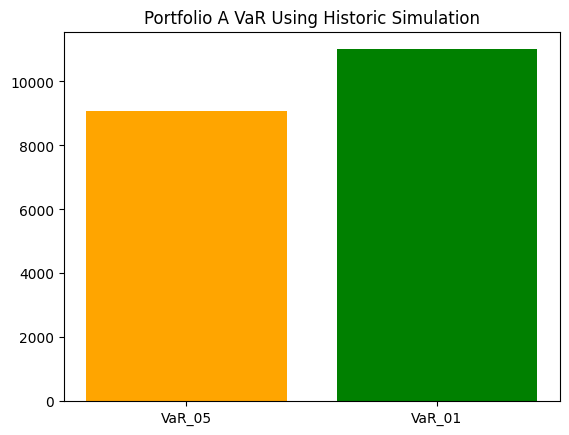

In [40]:
# historic simulation
# portfolio a

hs_a = np.random.randint(low = 1, high = 248, size = N)
hs_return_a = np.zeros([N,len(stock_a)])
for i in range(N):
    for j in range(len(stock_a)):
        hs_return_a[i,j] = return_a.iloc[hs_a[i],j]

hs_price_a = (hs_return_a + 1) * np.array(DP_a[::-1].iloc[0,:])

hs_PV_a = np.dot(hs_price_a, np.array(portfolio_a['Holding']))
hs_PV_a = sorted(hs_PV_a) 

hs_index_05_a = int(0.05*N-1)
hs_index_01_a = int(0.01*N-1)

hs_VaR_05_a = PV_a - hs_PV_a[hs_index_05_a]
hs_VaR_01_a = PV_a - hs_PV_a[hs_index_01_a]

print(hs_VaR_05_a)
print(hs_VaR_01_a)
plt.title('Portfolio A VaR Using Historic Simulation')
plt.bar(['VaR_05','VaR_01'],[hs_VaR_05_a, hs_VaR_01_a],color = ['Orange','Green'])

In [88]:
all_return.iloc[:,1:]

,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,BRK-B,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,0.016127,0.023152,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,0.006109,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028572,0.013237
2,0.001121,-0.001389,-0.001167,0.010159,0.001041,0.008268,0.007784,-0.020181,0.000604,-0.001739,...,0.006757,-0.002429,0.005763,0.038879,0.009294,0.012244,0.003363,0.015301,-0.001389,-0.025984
3,-0.021361,-0.021269,-0.029282,-0.021809,-0.050943,-0.037746,-0.037669,-0.040778,-0.075591,-0.006653,...,-0.034949,0.005326,0.015017,-0.046988,-0.009855,0.004833,-0.030857,-0.031925,-0.033380,-0.028763
4,-0.006475,-0.009356,-0.009631,-0.013262,-0.022103,-0.016116,-0.013914,-0.007462,-0.035296,0.003987,...,-0.000646,-0.000908,0.007203,-0.000436,-0.003916,-0.005942,-0.013674,-0.004506,-0.003677,0.015038
5,-0.010732,-0.017812,-0.000729,-0.015753,-0.041366,-0.004521,-0.008163,-0.019790,-0.010659,-0.002033,...,0.009494,0.007121,-0.008891,0.003243,-0.001147,-0.000673,0.008342,-0.037654,-0.002246,-0.013605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,-0.010629,0.024400,-0.023621,-0.084315,0.009083,-0.027474,-0.032904,-0.011866,-0.028053,-0.010742,...,-0.004694,-0.011251,-0.001277,-0.002677,0.038211,0.004134,0.002336,-0.008916,-0.005954,0.001617
245,-0.006111,-0.017929,-0.006116,-0.011703,0.025161,-0.017942,-0.016632,-0.002520,-0.000521,-0.000259,...,-0.014451,0.003945,0.001066,-0.007102,0.022012,0.021826,-0.041181,0.005106,-0.009782,-0.004595
246,0.013079,0.019245,0.042022,-0.000685,0.010526,0.046064,0.044167,0.029883,0.051401,0.014720,...,-0.000368,-0.016473,-0.008518,0.019544,-0.003590,-0.001641,0.003573,0.001451,0.008669,-0.003618
247,-0.010935,-0.017653,-0.003102,-0.020174,0.022763,-0.076830,-0.074417,-0.042741,0.001443,-0.014346,...,-0.008469,-0.004456,-0.001289,-0.018009,-0.004416,0.002819,-0.015526,0.004106,-0.015391,0.009363


7078.514761769562
10302.531264178164


<BarContainer object of 2 artists>

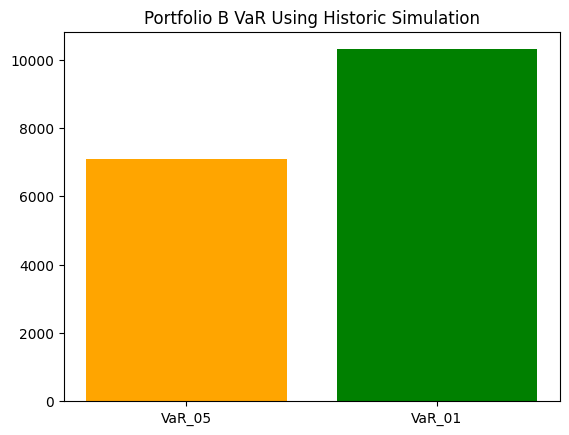

In [41]:
# portfolio b

hs_b = np.random.randint(low = 1, high = 248, size = N)
hs_return_b = np.zeros([N,len(stock_b)])
for i in range(N):
    for j in range(len(stock_b)):
        hs_return_b[i,j] = return_b.iloc[hs_b[i],j]

hs_price_b = (hs_return_b + 1) * np.array(DP_b[::-1].iloc[0,:])

hs_PV_b = np.dot(hs_price_b, np.array(portfolio_b['Holding']))
hs_PV_b = sorted(hs_PV_b) 

hs_index_05_b = int(0.05*N-1)
hs_index_01_b = int(0.01*N-1)

hs_VaR_05_b = PV_b - hs_PV_b[hs_index_05_b]
hs_VaR_01_b = PV_b - hs_PV_b[hs_index_01_b]

print(hs_VaR_05_b)
print(hs_VaR_01_b)
plt.title('Portfolio B VaR Using Historic Simulation')
plt.bar(['VaR_05','VaR_01'],[hs_VaR_05_b, hs_VaR_01_b],color = ['Orange','Green'])

In [85]:
all_return.iloc[[1,1,2,3,4],1].sort_values()

3   -0.021361
5   -0.010732
4   -0.006475
2    0.001121
2    0.001121
Name: SPY, dtype: float64

5802.65286111302
8355.846512456133


<BarContainer object of 2 artists>

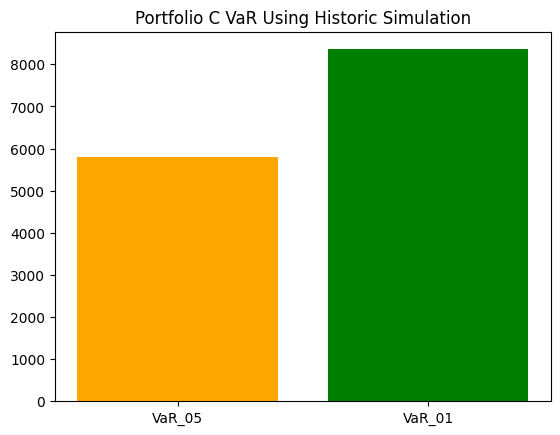

In [42]:
# portfolio c

hs_c = np.random.randint(low = 1, high = 248, size = N)
hs_return_c = np.zeros([N,len(stock_c)])
for i in range(N):
    for j in range(len(stock_c)):
        hs_return_c[i,j] = return_c.iloc[hs_c[i],j]

hs_price_c = (hs_return_c + 1) * np.array(DP_c[::-1].iloc[0,:])

hs_PV_c = np.dot(hs_price_c, np.array(portfolio_c['Holding']))
hs_PV_c = sorted(hs_PV_c) 

hs_index_05_c = int(0.05*N-1)
hs_index_01_c = int(0.01*N-1)

hs_VaR_05_c = PV_c - hs_PV_c[hs_index_05_c]
hs_VaR_01_c = PV_c - hs_PV_c[hs_index_01_c]

print(hs_VaR_05_c)
print(hs_VaR_01_c)
plt.title('Portfolio C VaR Using Historic Simulation')
plt.bar(['VaR_05','VaR_01'],[hs_VaR_05_c, hs_VaR_01_c],color = ['Orange','Green'])

21408.833521795576
30824.58669111191


<BarContainer object of 2 artists>

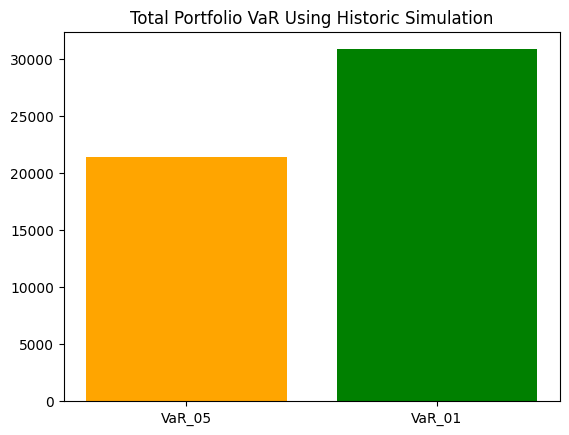

In [43]:
hs = np.random.randint(low = 1, high = 248, size = N)
hs_return = np.zeros([N,len(stock_t)])
for i in range(N):
    for j in range(len(stock_t)):
        hs_return[i,j] = return_t.iloc[hs[i],j]

hs_price = (hs_return + 1) * np.array(DP_t[::-1].iloc[0,:])

hs_PV = np.dot(hs_price, np.array(portfolio_t['Holding']))
hs_PV = sorted(hs_PV) 

hs_index_05 = int(0.05*N-1)
hs_index_01 = int(0.01*N-1)

hs_VaR_05 = PV_t - hs_PV[hs_index_05]
hs_VaR_01 = PV_t - hs_PV[hs_index_01]

print(hs_VaR_05)
print(hs_VaR_01)
plt.title('Total Portfolio VaR Using Historic Simulation')
plt.bar(['VaR_05','VaR_01'],[hs_VaR_05, hs_VaR_01],color = ['Orange','Green'])

7972.332369585405
11369.452168426942


<BarContainer object of 2 artists>

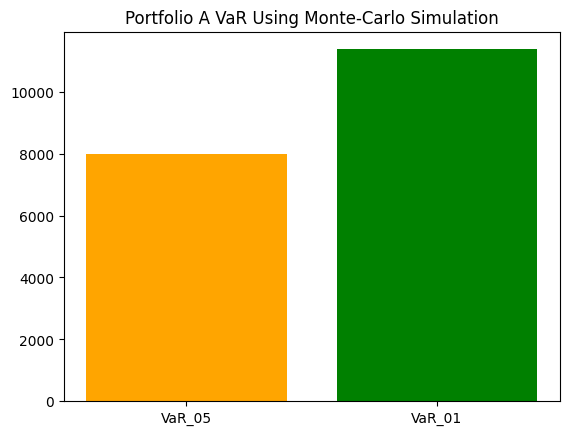

In [44]:
# Using original covariance for returns
# portfolio A

portfolio_a = portfolio[portfolio['Portfolio']=='A']
stock_a = portfolio_a['Stock']
return_a = all_return[stock_a]
cov_a = all_return[stock_a].cov()
DP_a = DP[stock_a]
PV_a = 0
for i in range(len(stock_a)):
    PV_a += DP_a[::-1].iloc[0,:][i] * portfolio_a['Holding'].iloc[i]
    
sim_return_a = np.random.multivariate_normal(np.zeros(len(stock_a)),cov_a,size = N)
sim_price_a = (sim_return_a + 1) * np.array(DP_a[::-1].iloc[0,:])
sim_PV_a = np.dot(sim_price_a, np.array(portfolio_a['Holding']))
sim_PV_a = sorted(sim_PV_a)

index_05_a = int(0.05*N-1)
index_01_a = int(0.01*N-1)

VaR_05_a = PV_a - sim_PV_a[index_05_a]
VaR_01_a = PV_a - sim_PV_a[index_01_a]

print(VaR_05_a)
print(VaR_01_a)
plt.title('Portfolio A VaR Using Monte-Carlo Simulation')
plt.bar(['VaR_05','VaR_01'],[VaR_05_a, VaR_01_a],color = ['Orange','Green'])

In [87]:
sim_price_a

array([[150.33372411, 191.56209159, 141.92919946, ..., 179.22075228,
        261.74639345,  80.66082231],
       [151.07465996, 199.81804206, 138.97566091, ..., 177.78861714,
        260.6620219 ,  80.35430777],
       [153.3157226 , 215.68227288, 139.2403373 , ..., 180.79694561,
        264.55978864,  80.41919855],
       ...,
       [154.79796957, 224.32605009, 143.33296726, ..., 182.67067189,
        273.15621474,  84.39057684],
       [156.25574275, 222.88241013, 139.08633955, ..., 182.16039776,
        269.20994479,  82.99716218],
       [147.57668219, 201.02792221, 136.15102807, ..., 174.3771412 ,
        260.20016256,  77.60521028]])

6716.18523051322
9641.705633676494


<BarContainer object of 2 artists>

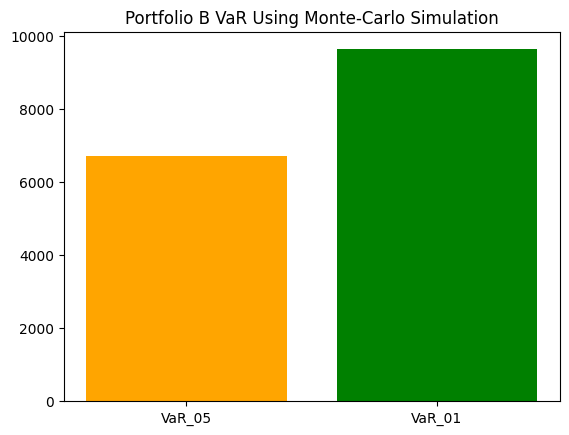

In [45]:
# portfolio B
portfolio_b = portfolio[portfolio['Portfolio']=='B']
stock_b = portfolio_b['Stock']
return_b = all_return[stock_b]
cov_b = all_return[stock_b].cov()
DP_b = DP[stock_b]
PV_b = 0
for i in range(len(stock_b)):
    PV_b += DP_b[::-1].iloc[0,:][i] * portfolio_b['Holding'].iloc[i]

sim_return_b = np.random.multivariate_normal(np.zeros(len(stock_b)),cov_b,size = N)
sim_price_b = (sim_return_b + 1) * np.array(DP_b[::-1].iloc[0,:])
sim_PV_b = np.dot(sim_price_b, np.array(portfolio_b['Holding']))
sim_PV_b = sorted(sim_PV_b)

index_05_b = int(0.05*N-1)
index_01_b = int(0.01*N-1)

VaR_05_b = PV_b - sim_PV_b[index_05_b]
VaR_01_b = PV_b - sim_PV_b[index_01_b]

print(VaR_05_b)
print(VaR_01_b)
plt.title('Portfolio B VaR Using Monte-Carlo Simulation')
plt.bar(['VaR_05','VaR_01'],[VaR_05_b, VaR_01_b],color = ['Orange','Green'])

5797.460296036967
8248.695635286887


<BarContainer object of 2 artists>

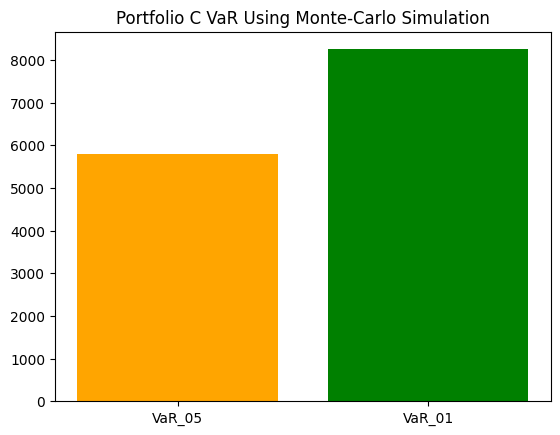

In [46]:
# portfolio C
portfolio_c = portfolio[portfolio['Portfolio']=='C']
stock_c = portfolio_c['Stock']
return_c = all_return[stock_c]
cov_c = all_return[stock_c].cov()
DP_c = DP[stock_c]
PV_c = 0
for i in range(len(stock_c)):
    PV_c += DP_c[::-1].iloc[0,:][i] * portfolio_c['Holding'].iloc[i]

sim_return_c = np.random.multivariate_normal(np.zeros(len(stock_c)),cov_c,size = N)
sim_price_c = (sim_return_c + 1) * np.array(DP_c[::-1].iloc[0,:])
sim_PV_c = np.dot(sim_price_c, np.array(portfolio_c['Holding']))
sim_PV_c = sorted(sim_PV_c)

index_05_c = int(0.05*N-1)
index_01_c = int(0.01*N-1)

VaR_05_c = PV_c - sim_PV_c[index_05_c]
VaR_01_c = PV_c - sim_PV_c[index_01_c]

print(VaR_05_c)
print(VaR_01_c)
plt.title('Portfolio C VaR Using Monte-Carlo Simulation')
plt.bar(['VaR_05','VaR_01'],[VaR_05_c, VaR_01_c],color = ['Orange','Green'])

20442.564457861707
28327.321868887055


<BarContainer object of 2 artists>

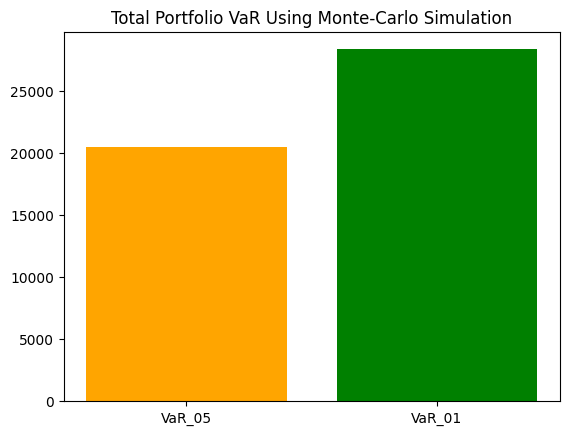

In [47]:
# Total portfolio
portfolio_t = portfolio
stock_t = portfolio_t['Stock']
return_t = all_return[stock_t]
cov_t = all_return[stock_t].cov()
DP_t = DP[stock_t]
PV_t = 0
for i in range(len(stock_t)):
    PV_t += DP_t[::-1].iloc[0,:][i] * portfolio_t['Holding'].iloc[i]

sim_return_t = np.random.multivariate_normal(np.zeros(len(stock_t)),cov_t,size = N)
sim_price_t = (sim_return_t + 1) * np.array(DP_t[::-1].iloc[0,:])
sim_PV_t = np.dot(sim_price_t, np.array(portfolio_t['Holding']))
sim_PV_t = sorted(sim_PV_t)

index_05_t = int(0.05*N-1)
index_01_t = int(0.01*N-1)

VaR_05_t = PV_t - sim_PV_t[index_05_t]
VaR_01_t = PV_t - sim_PV_t[index_01_t]

print(VaR_05_t)
print(VaR_01_t)
plt.title('Total Portfolio VaR Using Monte-Carlo Simulation')
plt.bar(['VaR_05','VaR_01'],[VaR_05_t, VaR_01_t],color = ['Orange','Green'])